<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch05_proximal_gradient_lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the Proximal Gradient to solve problems:
$$ \text{minimize}_{x\in \mathbb{R}^n} ~~f(x)+g(x)$$
where $f(x)$ is convex, smooth, and $g(x)$ is convex, non-smooth, (possibly non-differentiable). We can use $g$ as an indicator function to encode convex constraints.

On this instance, we are solving the well-known LASSO optimization that is used to recover sparse signals, e.g., to de-noise an image.
$$\text{minimize}_{x\in\mathbb{R}^n}\frac{1}2\|Ax-b\|^2+\lambda\|x\|_1$$

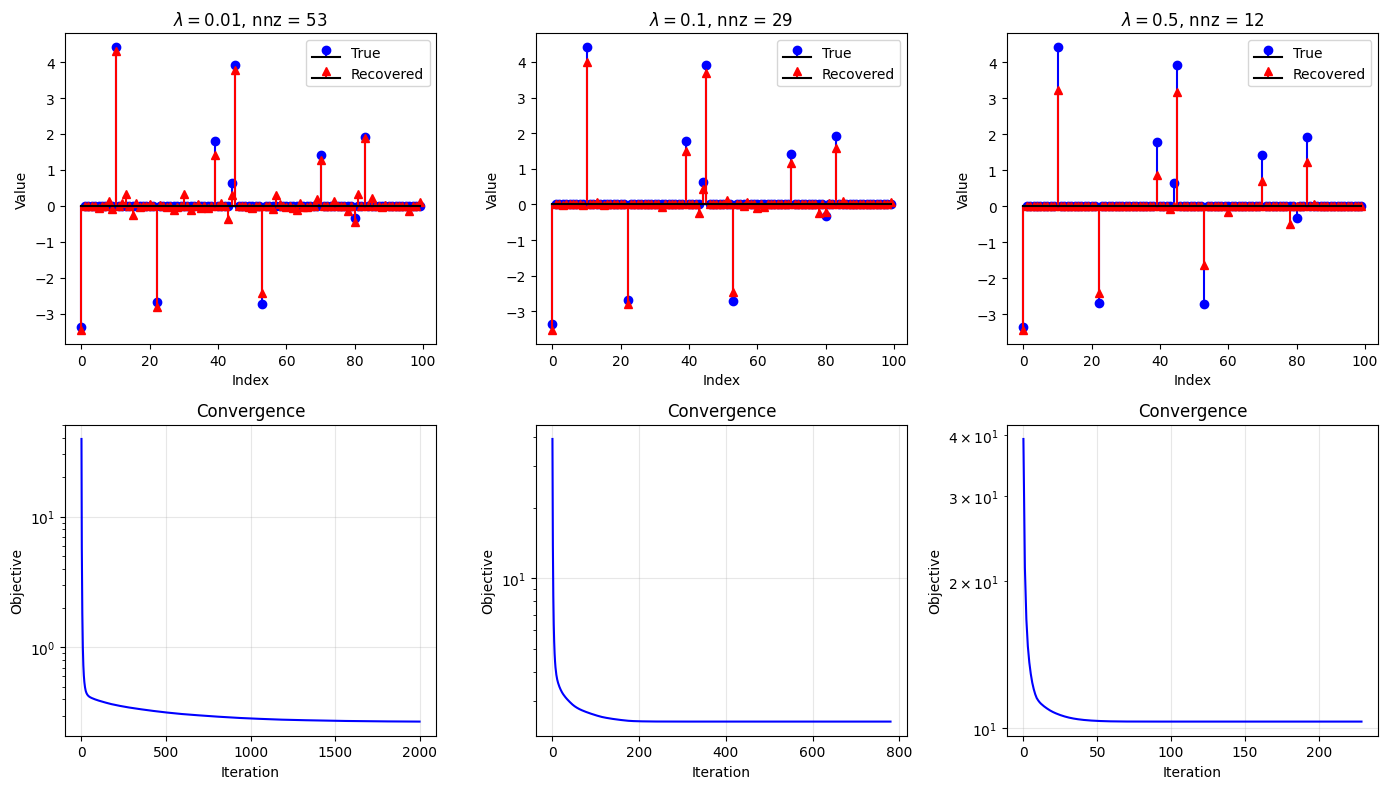

True sparsity: 10
Recovery error (lambda=0.1): 2.4212


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def lasso_ista(A, b, lambda_reg, max_iter=1000, tol=1e-6):
    """
    Solve LASSO via ISTA (proximal gradient).
    min_x 0.5 * ||Ax - b||^2 + lambda * ||x||_1
    """

    m, n = A.shape
    x = np.zeros(n)

    # Smoothness constant
    M = np.linalg.norm(A.T @ A, 2) # Spectral norm
    eta = 1.0 / M

    # Precompute
    AtA = A.T @ A
    Atb = A.T @ b

    history = {'objective': [], 'sparsity': []}

    for k in range(max_iter):
        # Compute objective
        residual = A @ x - b
        obj = 0.5 * np.sum(residual**2) + lambda_reg * np.sum(np.abs(x))
        history['objective'].append(obj)
        history['sparsity'].append(np.sum(np.abs(x) > 1e-8))

        # Gradient step
        grad = AtA @ x - Atb
        y = x - eta * grad

        # Proximal step (soft-thresholding)
        x_new = prox_l1(y, eta * lambda_reg)

        # Check convergence
        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            break

        x = x_new

    return x, history

def demo_lasso():
    """Demonstrate LASSO for sparse recovery."""
    np.random.seed(42)

    # Problem setup: recover sparse signal
    n = 100 # Signal dimension
    m = 50 # Number of measurements
    k = 10 # Sparsity (number of nonzeros)

    # True sparse signal
    x_true = np.zeros(n)
    support = np.random.choice(n, k, replace=False)
    x_true[support] = np.random.randn(k) * 3

    # Measurement matrix and observations
    A = np.random.randn(m, n) / np.sqrt(m)
    b = A @ x_true + 0.1 * np.random.randn(m) # Noisy measurements

    # Solve LASSO for different lambda values
    lambdas = [0.01, 0.1, 0.5]

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    for i, lam in enumerate(lambdas):
        x_est, history = lasso_ista(A, b, lam, max_iter=2000)

        # Plot recovered signal
        axes[0, i].stem(x_true, linefmt='b-', markerfmt='bo', basefmt='k-', label='True')
        axes[0, i].stem(x_est, linefmt='r-', markerfmt='r^', basefmt='k-', label='Recovered')
        axes[0, i].set_title(f'$\\lambda = {lam}$, nnz = {np.sum(np.abs(x_est) > 1e-4)}')
        axes[0, i].legend()
        axes[0, i].set_xlabel('Index')
        axes[0, i].set_ylabel('Value')

        # Plot convergence
        axes[1, i].semilogy(history['objective'], 'b-')
        axes[1, i].set_xlabel('Iteration')
        axes[1, i].set_ylabel('Objective')
        axes[1, i].set_title('Convergence')
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('lasso_demo.pdf', bbox_inches='tight')
    plt.show()

    print(f"True sparsity: {k}")
    print(f"Recovery error (lambda=0.1): {np.linalg.norm(x_est - x_true):.4f}")

demo_lasso()